In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import h5py

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Input, Dropout, Flatten, Conv2D,MaxPool2D
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras.regularizers import l1, l2

from tensorflow.keras import utils
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pydot
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

import pickle
import json

In [2]:
tf.__version__

'2.9.1'

In [3]:
hdf5_x_file = 'dataset/camelyonpatch_x.h5'
hdf5_y_file = 'dataset/camelyonpatch_y.h5'

hfx = h5py.File(hdf5_x_file, 'r')
hfy = h5py.File(hdf5_y_file, 'r')

X = hfx['x']
y = hfy['y']

print("X shape = ",X.shape)
print("y shape = ",y.shape)

X shape =  (32768, 96, 96, 3)
y shape =  (32768, 1, 1, 1)


### Konvertovanje u np.array

In [4]:
X = np.array(X)
y = np.array(y)

### Reshape iz  4D u 2D

In [5]:
nsamples, nx, ny, nrgb = X.shape
X_reshape = X.reshape((nsamples,nx*ny*nrgb))
print('2D X shape = ',X_reshape.shape)

y_reshape = y.ravel()
print('2D y shape = ',y_reshape.shape)

2D X shape =  (32768, 27648)
2D y shape =  (32768,)


In [6]:
print(X_reshape)

[[247 246 244 ... 243 241 244]
 [216 166 203 ... 227 213 226]
 [184 155 186 ... 251 205 242]
 ...
 [223 159 183 ... 192 113 160]
 [154  75 192 ...  67  10 107]
 [ 64   2  39 ... 197 137 165]]


In [7]:
print(y_reshape)

[0 1 0 ... 1 1 0]


### Podela na Train, Test i Validate podatke

In [8]:
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X_reshape, y_reshape, test_size = 0.2, random_state = 42, stratify = y_reshape )
X_train, X_validation, y_train, y_validation = train_test_split(X_train_and_val, y_train_and_val, test_size = 0.25, random_state = 42, stratify = y_train_and_val)

In [9]:
X_train.shape

(19660, 27648)

In [10]:
X_test.shape

(6554, 27648)

In [11]:
X_validation.shape

(6554, 27648)

In [12]:
print(X_train)

[[254 233 238 ... 151 120 128]
 [178 130 190 ... 174  70 169]
 [ 60  23 126 ... 167 103 199]
 ...
 [215 210 217 ... 242 179 250]
 [246 161 220 ... 121  49 161]
 [ 77  34  64 ... 128  85 105]]


In [13]:
print(y_train)

[0 1 1 ... 1 1 0]


In [14]:
print(X_test)

[[121  86 128 ... 252 252 252]
 [242 242 242 ... 193  68 208]
 [174 141 158 ... 115  63  65]
 ...
 [220 113 207 ... 227 217 242]
 [171  66 185 ... 238 223 255]
 [221 225 224 ... 187 126 186]]


In [15]:
print(y_test)

[1 1 0 ... 0 1 0]


In [16]:
print(X_validation)

[[241 229 241 ... 229 224 231]
 [227 161 223 ...  58  34 144]
 [173  85 127 ... 134  63  97]
 ...
 [121  89 165 ... 159  97 183]
 [ 76  46 146 ... 214 167 222]
 [184  68 169 ... 253 219 254]]


In [17]:
print(y_validation)

[0 0 1 ... 0 1 1]


### Brisanje suvišnih podataka iz memorije i zatvaranje fajlova

In [18]:
del X, y, X_reshape, y_reshape

In [19]:
hfx.close()
hfy.close()

### Pravljenje kopija
Zbog rada na konvolutivnoj neuralnoj mrezi, pravim kopiju za X_test, X_train i X_validate.
Trebaju mi nestandardizovane kopije, jer za konvolutivnu normalizujem podatke

In [20]:
X_train_copy = X_train
X_validation_copy = X_validation
X_test_copy = X_test

### Provera stratifikovanosti

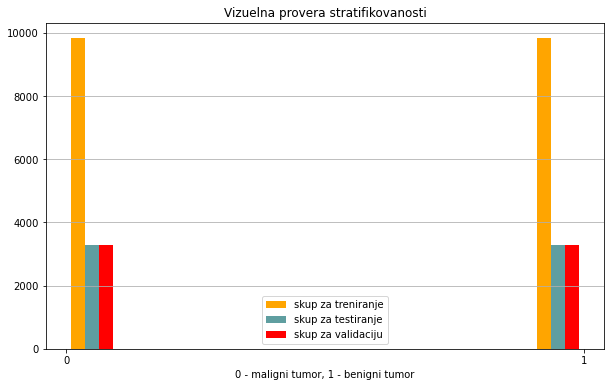

In [21]:
plt.figure(figsize = (10,6))
plt.title('Vizuelna provera stratifikovanosti')
plt.xticks([0,1])
plt.xlabel('0 - maligni tumor, 1 - benigni tumor')
plt.hist([y_train, y_test, y_validation], color=['orange', 'cadetblue', 'red'], label=['skup za treniranje', 'skup za testiranje','skup za validaciju'])
plt.legend(loc='best')
plt.grid(axis = 'y')
plt.show()

In [22]:
benigni_train = np.sum(y_train==1)
print('Broj pozitivnih instanci trening seta: ', benigni_train)
maligni_train = np.sum(y_train==0)
print('Broj negativnih instanci trening seta: ', maligni_train)
odstupanje = np.abs(benigni_train - maligni_train)
procenat_odstupanja = odstupanje*100/X_train.shape[0]
print('Odstupanje: {0:d} ({1:.2f}%)\n=========================\n'.format(odstupanje, procenat_odstupanja))

benigni_test = np.sum(y_test==1)
print('Broj pozitivnih instanci test seta: ', benigni_test)
maligni_test = np.sum(y_test==0)
print('Broj negativnih instanci test seta: ', maligni_test)
odstupanje = np.abs(benigni_test - maligni_test)
procenat_odstupanja = odstupanje*100/X_test.shape[0]
print('Odstupanje: {0:d} ({1:.2f}%)\n=========================\n'.format(odstupanje, procenat_odstupanja))

benigni_val = np.sum(y_validation==1)
print('Broj pozitivnih instanci validacionog seta: ', benigni_val)
maligni_val = np.sum(y_validation==0)
print('Broj negativnih instanci validacionog seta: ', maligni_val)
odstupanje = np.abs(benigni_val - maligni_val)
procenat_odstupanja = odstupanje*100/X_validation.shape[0]
print('Odstupanje: {0:d} ({1:.2f}%)\n=========================\n'.format(odstupanje, procenat_odstupanja))

Broj pozitivnih instanci trening seta:  9826
Broj negativnih instanci trening seta:  9834
Odstupanje: 8 (0.04%)

Broj pozitivnih instanci test seta:  3276
Broj negativnih instanci test seta:  3278
Odstupanje: 2 (0.03%)

Broj pozitivnih instanci validacionog seta:  3275
Broj negativnih instanci validacionog seta:  3279
Odstupanje: 4 (0.06%)



### Standardizacija

In [23]:
scaler_t = StandardScaler()
scaler_t.fit(X_train)
X_train = scaler_t.transform(X_train)
X_validation = scaler_t.transform(X_validation)

In [24]:
scaler_tv = StandardScaler()
scaler_tv.fit(X_train_and_val)
X_train_and_val = scaler_tv.transform(X_train_and_val)
X_test = scaler_tv.transform(X_test)

In [25]:
with open('assets/standard_scaler/ANN_Train_scaler.scaler.pickle', 'wb') as scaler_file:
    pickle.dump(scaler_t, scaler_file)

In [26]:
with open('assets/standard_scaler//ANN_Train_and_Validation_scaler.scaler.pickle', 'wb') as scaler_file:
    pickle.dump(scaler_tv, scaler_file)

In [27]:
#Ovde nam neće trebati ovaj skup podataka
del X_train_and_val

In [28]:
print(X_train)

[[ 1.30910312  1.38902285  1.17899234 ... -0.39282128 -0.21108891
  -0.94294384]
 [ 0.08647567 -0.03866716  0.26224548 ... -0.02588697 -0.89542089
  -0.17817272]
 [-1.81181431 -1.52180144 -0.96008367 ... -0.13756263 -0.44376179
   0.38141591]
 ...
 [ 0.68170219  1.07021828  0.77791559 ...  1.05896227  0.59642281
   1.33271658]
 [ 1.1804055   0.39102595  0.83521227 ... -0.87143124 -1.18284032
  -0.32739635]
 [-1.53833186 -1.36932969 -2.14421502 ... -0.75975558 -0.6901213
  -1.37196179]]


In [29]:
print(X_test)

[[-0.82465962 -0.64608368 -0.9201372  ...  1.22047286  1.59752775
   1.3723488 ]
 [ 1.11346154  1.50732707  1.25023735 ...  0.28118425 -0.92216486
   0.55153983]
 [ 0.02426949  0.11313165 -0.348986   ... -0.96058714 -0.99063477
  -2.11608934]
 ...
 [ 0.76107588 -0.27337797  0.58389429 ...  0.82246921  1.11823839
   1.18580131]
 [-0.02378311 -0.92216198  0.16505007 ...  0.99759082  1.20040228
   1.42831305]
 [ 0.77709341  1.27266051  0.90754663 ...  0.18566337 -0.12791393
   0.14113534]]


In [30]:
print(X_validation)

[[ 1.09996948  1.33357857  1.23628902 ...  0.85156462  1.21232159
   0.97831045]
 [ 0.87474863  0.39102595  0.89250895 ... -1.87651215 -1.38813991
  -0.64449657]
 [ 0.00603966 -0.66241522 -0.94098477 ... -0.66403359 -0.99122736
  -1.52118542]
 ...
 [-0.83049491 -0.60697095 -0.21522684 ... -0.26519195 -0.52588162
   0.08296864]
 [-1.55441906 -1.20299688 -0.57810581 ...  0.61225964  0.43218314
   0.81043386]
 [ 0.18299889 -0.89805338 -0.13883127 ...  1.23445259  1.14388839
   1.4073284 ]]


# 1.1. Neuronska mreža

### Kreiranje mreže

In [31]:
ann = Sequential()

In [32]:
ann.add(InputLayer(input_shape=(nx*ny*nrgb)))
ann.add(Dense(units=int(nx*ny/(nrgb**3)), activation='relu'))
ann.add(Dense(units=128, activation='relu'))
ann.add(Dense(units=64, activation='relu'))
ann.add(Dense(units=1, activation='sigmoid'))

### Opis mreže

In [33]:
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 341)               9428309   
                                                                 
 dense_1 (Dense)             (None, 128)               43776     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,480,406
Trainable params: 9,480,406
Non-trainable params: 0
_________________________________________________________________


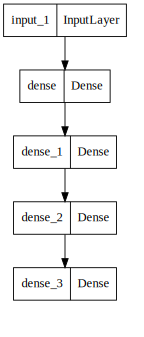

In [166]:
display(SVG(model_to_dot(ann, dpi=65).create(prog='dot', format='svg')))

### Treniranje mreže

In [35]:
ann.compile(loss='binary_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy'])

In [36]:
history = ann.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=128,
                  validation_data=(X_validation, y_validation))

Epoch 1/50
154/154 [==============================] - 45s 282ms/step - loss: 1.5526 - accuracy: 0.6611 - val_loss: 0.5917 - val_accuracy: 0.7287
Epoch 2/50
154/154 [==============================] - 18s 118ms/step - loss: 0.4752 - accuracy: 0.8040 - val_loss: 0.6142 - val_accuracy: 0.7402
Epoch 3/50
154/154 [==============================] - 17s 111ms/step - loss: 0.3725 - accuracy: 0.8562 - val_loss: 0.6770 - val_accuracy: 0.7280
Epoch 4/50
154/154 [==============================] - 16s 107ms/step - loss: 0.2601 - accuracy: 0.9020 - val_loss: 0.7321 - val_accuracy: 0.7336
Epoch 5/50
154/154 [==============================] - 17s 109ms/step - loss: 0.2156 - accuracy: 0.9222 - val_loss: 0.7039 - val_accuracy: 0.7608
Epoch 6/50
154/154 [==============================] - 17s 109ms/step - loss: 0.1481 - accuracy: 0.9492 - val_loss: 0.8622 - val_accuracy: 0.7528
Epoch 7/50
154/154 [==============================] - 17s 108ms/step - loss: 0.1063 - accuracy: 0.9659 - val_loss: 0.8123 - val_ac

### Ocena neuronske mreže

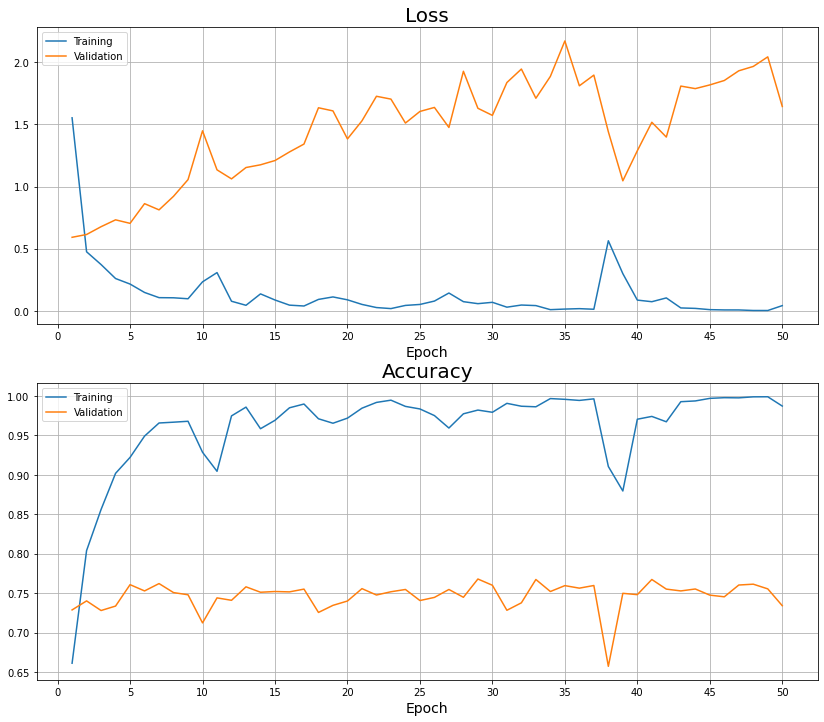

In [153]:
plt.figure(figsize=(14,12))

plt.subplot(2, 1, 1)

plt.plot(np.arange(1, 51), history.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history.history['val_loss'], label='Validation')
plt.title('Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()


plt.subplot(2, 1, 2)

plt.plot(np.arange(1, 51), history.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()

plt.savefig('assets/pictures/1.DM_1_ANN_Loss_Acc_first_try.jpg')

plt.show()

### Evaluacija

In [38]:
loss = ann.metrics_names[0]
acc = ann.metrics_names[1]

In [39]:
print('Evaluacija nad trening podacima:\n')

train_scores = ann.evaluate(X_train, y_train, batch_size=128)
print('{0}: {1}'.format(loss, train_scores[0]))
print('{0}: {1}'.format(acc, train_scores[1]))

Evaluacija nad trening podacima:

154/154 [==============================] - 8s 49ms/step - loss: 0.1070 - accuracy: 0.9547
loss: 0.1069684773683548
accuracy: 0.954679548740387


In [40]:
print('Evaluacija nad test podacima:\n')

test_scores = ann.evaluate(X_test, y_test, batch_size=128)
print('Test set {0}: {1}'.format(loss, test_scores[0]))
print('Test set {0}: {1}'.format(acc, test_scores[1]))

Evaluacija nad test podacima:

52/52 [==============================] - 4s 55ms/step - loss: 1.5719 - accuracy: 0.7441
Test set loss: 1.5719369649887085
Test set accuracy: 0.7441257238388062


### Čuvanje modela neuronske mreže

In [41]:
with open('models/deep_models/DC_1_ANN_first_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(ann, model_file)

INFO:tensorflow:Assets written to: ram://686292ac-eece-40ad-8c43-c6136adc53fb/assets


**Na osnovu grafika i rezultata može se primetiti da je model preprilagodjen. 
Naredni pokušaj je sa tehnikama regularizacije.**

# 1.2. Neuronska mreža sa regularizacijom

### Kreiranje mreže

In [42]:
ann2 = Sequential()

ann2.add(InputLayer(input_shape=(nx*ny*nrgb)))
ann2.add(Dense(units=int(nx*ny/(nrgb**3)), activation='relu', kernel_regularizer=l2(l=0.01)))
ann2.add(Dropout(rate=0.4))
ann2.add(Dense(units=128, activation='relu', kernel_regularizer=l2(l2=0.01)))
ann2.add(Dropout(rate=0.4))
ann2.add(Dense(units=64, activation='relu', activity_regularizer=l1(l1=0.001)))
ann2.add(Dropout(rate=0.3))
ann2.add(Dense(units=1, activation='sigmoid'))

### Opis mreže

In [43]:
ann2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 341)               9428309   
                                                                 
 dropout (Dropout)           (None, 341)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               43776     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

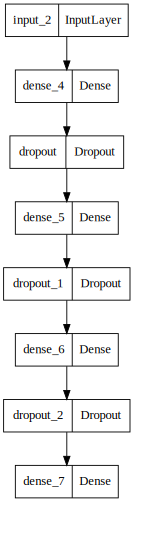

In [44]:
display(SVG(model_to_dot(ann2, dpi=65).create(prog='dot', format='svg')))

### Treniranje mreže

In [45]:
ann2.compile(loss='binary_crossentropy', 
             optimizer=Adam(learning_rate=0.001), 
             metrics=['accuracy'])

In [46]:
history2 = ann2.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_validation, y_validation))

Epoch 1/50
154/154 [==============================] - 62s 366ms/step - loss: 6.8999 - accuracy: 0.5884 - val_loss: 2.8229 - val_accuracy: 0.6707
Epoch 2/50
154/154 [==============================] - 27s 178ms/step - loss: 2.3175 - accuracy: 0.6367 - val_loss: 1.9452 - val_accuracy: 0.6532
Epoch 3/50
154/154 [==============================] - 25s 159ms/step - loss: 1.7639 - accuracy: 0.6535 - val_loss: 1.5692 - val_accuracy: 0.7048
Epoch 4/50
154/154 [==============================] - 24s 159ms/step - loss: 1.4523 - accuracy: 0.6633 - val_loss: 1.3235 - val_accuracy: 0.7150
Epoch 5/50
154/154 [==============================] - 24s 159ms/step - loss: 1.2254 - accuracy: 0.6731 - val_loss: 1.1644 - val_accuracy: 0.6924
Epoch 6/50
154/154 [==============================] - 25s 159ms/step - loss: 1.0593 - accuracy: 0.6709 - val_loss: 0.9813 - val_accuracy: 0.7075
Epoch 7/50
154/154 [==============================] - 24s 159ms/step - loss: 0.9536 - accuracy: 0.6818 - val_loss: 0.9007 - val_ac

### Ocena neuronske mreže nakon regularizacije

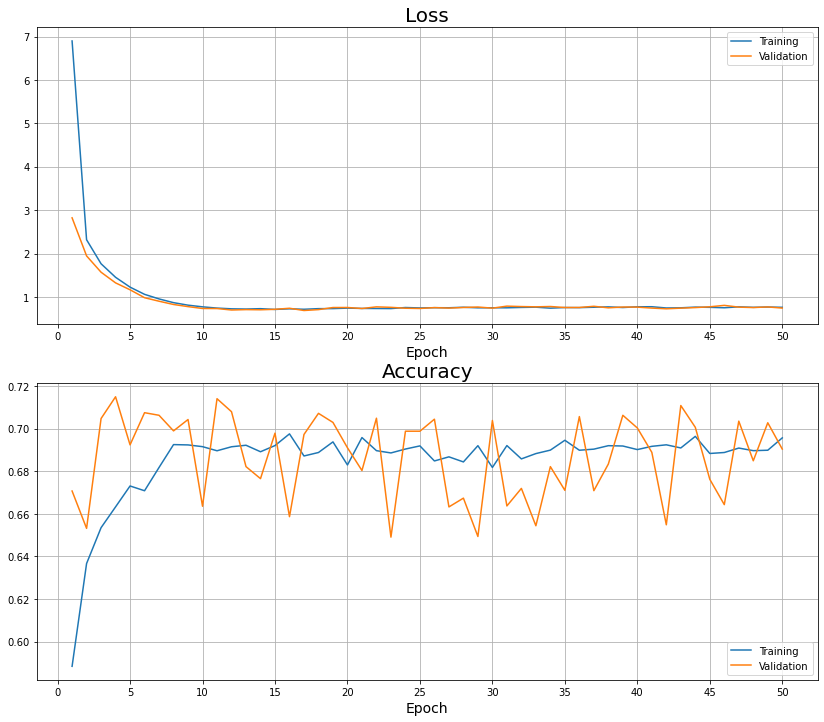

In [154]:
plt.figure(figsize=(14,12))

plt.subplot(2, 1, 1)

plt.plot(np.arange(1, 51), history2.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history2.history['val_loss'], label='Validation')
plt.title('Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()


plt.subplot(2, 1, 2)

plt.plot(np.arange(1, 51), history2.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history2.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()

plt.savefig('assets/pictures/2.DM_1_ANN_Loss_Acc_second_try.jpg')

plt.show()

### Evaluacija nakon regularizacije

In [48]:
print('Evaluacija nad trening podacima:\n')

train_scores2 = ann2.evaluate(X_train, y_train, batch_size=128)
print('{0}: {1}'.format(loss, train_scores2[0]))
print('{0}: {1}'.format(acc, train_scores2[1]))

Evaluacija nad trening podacima:

154/154 [==============================] - 8s 50ms/step - loss: 0.7358 - accuracy: 0.6913
loss: 0.735765278339386
accuracy: 0.691251277923584


In [49]:
print('Evaluacija nad test podacima:\n')

test_scores2 = ann2.evaluate(X_test, y_test, batch_size=128)
print('Test set {0}: {1}'.format(loss, test_scores2[0]))
print('Test set {0}: {1}'.format(acc, test_scores2[1]))

Evaluacija nad test podacima:

52/52 [==============================] - 4s 69ms/step - loss: 0.7360 - accuracy: 0.6922
Test set loss: 0.7360067963600159
Test set accuracy: 0.6922490000724792


### Čuvanje modela neuronske mreže

In [50]:
with open('models/deep_models/DC_1_ANN_second_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(ann2, model_file)

INFO:tensorflow:Assets written to: ram://5b328235-0084-4130-9186-0391a1cd2457/assets


# 2.1. Konvolutivna neuronska mreža

In [58]:
X_train = X_train_copy.reshape((X_train_copy.shape[0], nx, ny, nrgb))
X_validation = X_validation_copy.reshape((X_validation_copy.shape[0], nx, ny, nrgb))
X_test = X_test_copy.reshape((X_test_copy.shape[0], nx, ny, nrgb))

In [59]:
print("X_train shape = ",X_train.shape)
print("y_train shape = {} \n".format(y_train.shape))

print("X_validation shape = ",X_validation.shape)
print("y_validation shape = {} \n".format(y_validation.shape))

print("X_test shape = ",X_test.shape)
print("y_test shape = ",y_test.shape)

X_train shape =  (19660, 96, 96, 3)
y_train shape = (19660,) 

X_validation shape =  (6554, 96, 96, 3)
y_validation shape = (6554,) 

X_test shape =  (6554, 96, 96, 3)
y_test shape =  (6554,)


### Brisanje suvišnih podataka iz memorije 

In [60]:
# del X_train_copy, X_validation_copy, X_test_copy

### Normalizacija

In [61]:
X_train = X_train / 255
X_validation = X_validation / 255
X_test = X_test / 255

In [62]:
print(X_train)

[[[[0.99607843 0.91372549 0.93333333]
   [0.96470588 0.90588235 0.91764706]
   [0.91372549 0.87058824 0.88627451]
   ...
   [0.21568627 0.0627451  0.23529412]
   [0.21176471 0.09019608 0.25098039]
   [0.20392157 0.10588235 0.25882353]]

  [[1.         0.91372549 0.94509804]
   [0.96862745 0.89411765 0.91764706]
   [1.         0.98039216 1.        ]
   ...
   [0.33333333 0.17254902 0.3372549 ]
   [0.25098039 0.1254902  0.27058824]
   [0.2        0.09803922 0.23529412]]

  [[0.74901961 0.64705882 0.69803922]
   [0.9254902  0.83137255 0.88235294]
   [0.91372549 0.83137255 0.86666667]
   ...
   [0.29803922 0.13333333 0.2745098 ]
   [0.23921569 0.10196078 0.22745098]
   [0.22745098 0.10980392 0.21960784]]

  ...

  [[0.81176471 0.63921569 0.72941176]
   [0.79215686 0.62745098 0.72156863]
   [0.89803922 0.76078431 0.85490196]
   ...
   [0.8        0.63921569 0.75686275]
   [0.40392157 0.23921569 0.38823529]
   [0.31372549 0.14509804 0.31372549]]

  [[0.96470588 0.80392157 0.86666667]
   [0.7

In [63]:
print(X_validation)

[[[[0.94509804 0.89803922 0.94509804]
   [0.89803922 0.86666667 0.90980392]
   [0.82352941 0.81176471 0.83921569]
   ...
   [1.         0.9254902  1.        ]
   [0.87843137 0.8745098  0.90588235]
   [0.85490196 0.93333333 0.92941176]]

  [[1.         0.91764706 1.        ]
   [0.9372549  0.85490196 0.92941176]
   [0.88235294 0.83529412 0.89019608]
   ...
   [1.         0.90196078 1.        ]
   [0.94901961 0.90196078 0.95686275]
   [0.89411765 0.9254902  0.9372549 ]]

  [[0.81960784 0.65882353 0.78431373]
   [0.96470588 0.82352941 0.93333333]
   [0.94901961 0.85098039 0.9372549 ]
   ...
   [0.58823529 0.39607843 0.52156863]
   [1.         0.95294118 1.        ]
   [0.8745098  0.85098039 0.89019608]]

  ...

  [[0.91372549 0.85882353 0.9254902 ]
   [0.89411765 0.84705882 0.90196078]
   [0.87843137 0.83529412 0.89019608]
   ...
   [0.89803922 0.87843137 0.90588235]
   [0.89803922 0.87843137 0.90588235]
   [0.89803922 0.87843137 0.90588235]]

  [[0.89803922 0.85098039 0.89803922]
   [0.8

In [64]:
print(X_test)

[[[[0.4745098  0.3372549  0.50196078]
   [0.63137255 0.49411765 0.65098039]
   [0.54901961 0.4        0.55294118]
   ...
   [0.70980392 0.54117647 0.64705882]
   [0.81960784 0.65098039 0.75686275]
   [0.74117647 0.58431373 0.69019608]]

  [[0.56862745 0.44313725 0.58823529]
   [0.61960784 0.48627451 0.62352941]
   [0.63137255 0.49411765 0.62352941]
   ...
   [0.96470588 0.76862745 0.88235294]
   [0.73333333 0.54117647 0.65882353]
   [0.77647059 0.58431373 0.70196078]]

  [[0.78823529 0.66666667 0.78823529]
   [0.68235294 0.55294118 0.6745098 ]
   [0.66666667 0.52941176 0.64705882]
   ...
   [0.84705882 0.61568627 0.74117647]
   [0.85098039 0.61568627 0.74901961]
   [0.94509804 0.70980392 0.84313725]]

  ...

  [[0.96470588 0.9372549  0.96470588]
   [0.98039216 0.95294118 0.98039216]
   [0.99607843 0.97647059 0.99215686]
   ...
   [0.98431373 0.97647059 0.98039216]
   [0.96078431 0.95686275 0.94901961]
   [0.99215686 0.97647059 0.97254902]]

  [[0.83137255 0.76470588 0.80392157]
   [0.9

### Kreiranje konvolutivne mreže

In [65]:
cnn = Sequential()

In [66]:
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[96, 96, 3]))
cnn.add(MaxPool2D(pool_size=2, strides=2))
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPool2D(pool_size=2, strides=2))
cnn.add(Flatten())
cnn.add(Dense(units=128, activation='relu'))
cnn.add(Dense(units=64, activation='relu'))
cnn.add(Dense(units=1, activation='sigmoid'))

### Sumacija postavke konvolutivne mreže

In [67]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 15488)             0         
                                                                 
 dense_8 (Dense)             (None, 128)              

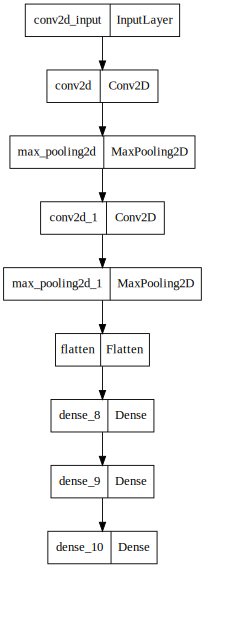

In [167]:
display(SVG(model_to_dot(cnn, dpi=65).create(prog='dot', format='svg')))

### Treniranje konvolutivne mreže

In [69]:
cnn.compile(optimizer = 'adam', 
            loss = 'binary_crossentropy', 
            metrics = ['accuracy'])

In [70]:
history_cnn = cnn.fit(x = X_train, 
                      y = y_train, 
                      validation_data = (X_validation, y_validation), 
                      epochs = 50)

Epoch 1/50
615/615 [==============================] - 123s 197ms/step - loss: 0.5159 - accuracy: 0.7527 - val_loss: 0.4453 - val_accuracy: 0.8036
Epoch 2/50
615/615 [==============================] - 112s 183ms/step - loss: 0.4389 - accuracy: 0.8039 - val_loss: 0.4128 - val_accuracy: 0.8207
Epoch 3/50
615/615 [==============================] - 113s 184ms/step - loss: 0.3964 - accuracy: 0.8285 - val_loss: 0.4304 - val_accuracy: 0.8114
Epoch 4/50
615/615 [==============================] - 113s 184ms/step - loss: 0.3415 - accuracy: 0.8556 - val_loss: 0.4239 - val_accuracy: 0.8200
Epoch 5/50
615/615 [==============================] - 112s 183ms/step - loss: 0.2744 - accuracy: 0.8909 - val_loss: 0.4633 - val_accuracy: 0.7946
Epoch 6/50
615/615 [==============================] - 115s 188ms/step - loss: 0.1945 - accuracy: 0.9248 - val_loss: 0.5059 - val_accuracy: 0.8164
Epoch 7/50
615/615 [==============================] - 112s 182ms/step - loss: 0.1198 - accuracy: 0.9573 - val_loss: 0.5610 -

### Evaluacija konvolutivne mreže

In [71]:
print('Evaluacija nad trening podacima:\n')

train_scores_cnn = cnn.evaluate(X_train, y_train, batch_size=128)
print('{0}: {1}'.format(loss, train_scores_cnn[0]))
print('{0}: {1}'.format(acc, train_scores_cnn[1]))

Evaluacija nad trening podacima:

154/154 [==============================] - 29s 185ms/step - loss: 6.9055e-07 - accuracy: 1.0000
loss: 6.905539180479536e-07
accuracy: 1.0


In [72]:
print('Evaluacija nad test podacima:\n')

test_scores_cnn = cnn.evaluate(X_test, y_test, batch_size=128)
print('{0}: {1}'.format(loss, test_scores_cnn[0]))
print('{0}: {1}'.format(acc, test_scores_cnn[1]))

Evaluacija nad test podacima:

52/52 [==============================] - 9s 169ms/step - loss: 2.1926 - accuracy: 0.8221
loss: 2.1925759315490723
accuracy: 0.8220933675765991


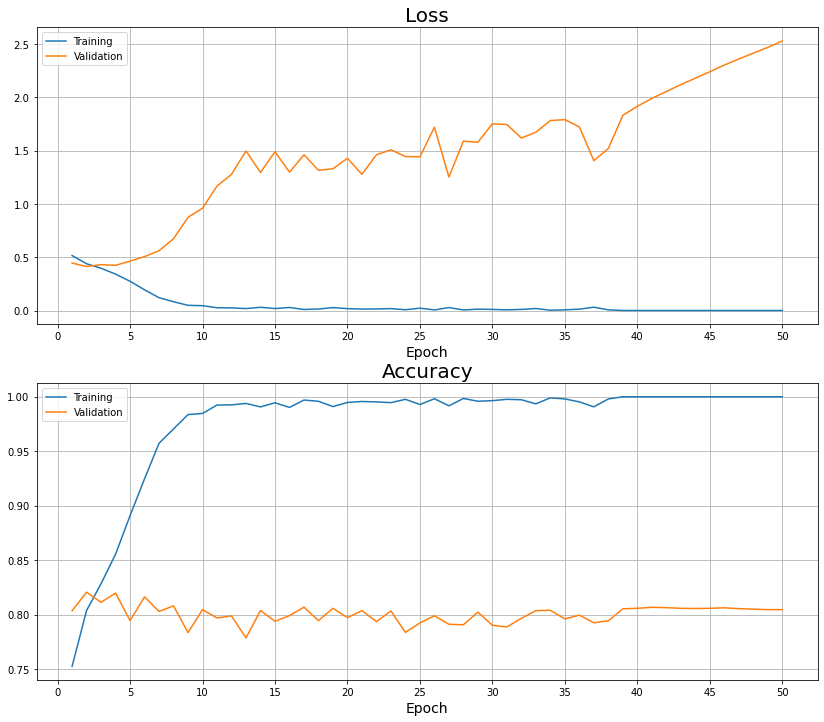

In [155]:
plt.figure(figsize=(14,12))

plt.subplot(2, 1, 1)

plt.plot(np.arange(1, 51), history_cnn.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history_cnn.history['val_loss'], label='Validation')
plt.title('Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()


plt.subplot(2, 1, 2)

plt.plot(np.arange(1, 51), history_cnn.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history_cnn.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()

plt.savefig('assets/pictures/3.DM_2_CNN_Loss_Acc_first_try.jpg')

plt.show()

### Čuvanje modela konvolutivne neuronske mreže

In [74]:
with open('models/deep_models/DC_2_CNN_first_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(cnn, model_file)

INFO:tensorflow:Assets written to: ram://1e066b30-042a-47eb-810e-bbdbfe0ad101/assets


INFO:tensorflow:Assets written to: ram://1e066b30-042a-47eb-810e-bbdbfe0ad101/assets


# 2.2 Konvolutivna mreža drugi pristup

### Kreiranje mreže

In [84]:
cnn2 = Sequential([Input(shape=[96,96,3]),
                   Conv2D(filters=32, kernel_size=3, activation='relu'),
                   MaxPool2D(pool_size=2, strides=2),
                   Conv2D(filters=32, kernel_size=3, activation='relu'),
                   MaxPool2D(pool_size=2, strides=2),
                   Dropout(0.25),
                   Flatten(),
                   Dense(128, activation='relu', kernel_regularizer=l2(l2=0.01)),
                   Dropout(0.5),
                   Dense(64, activation='relu', kernel_regularizer=l2(l2=0.01)),
                   Dropout(0.5),
                   Dense(1, activation='sigmoid')])

### Opis mreže

In [85]:
cnn2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 22, 22, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 15488)            

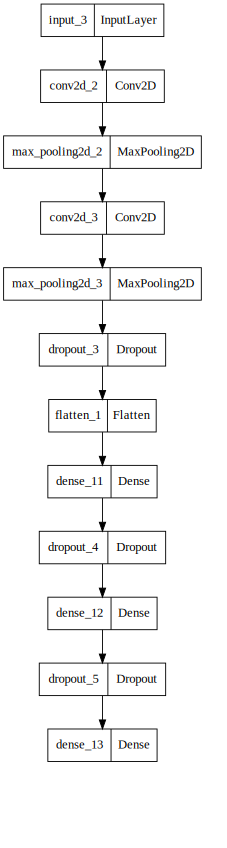

In [168]:
display(SVG(model_to_dot(cnn2, dpi=65).create(prog='dot', format='svg')))

### Treniranje mreže

In [87]:
cnn2.compile(loss='binary_crossentropy', 
             optimizer=Adam(learning_rate=0.001), 
             metrics=['accuracy'])

In [88]:
history_cnn2 = cnn2.fit(X_train,
                        y_train,
                        validation_data= (X_validation, y_validation),
                        batch_size=128,
                        epochs=50)

Epoch 1/50
154/154 [==============================] - 161s 1s/step - loss: 1.1717 - accuracy: 0.6927 - val_loss: 0.6602 - val_accuracy: 0.7424
Epoch 2/50
154/154 [==============================] - 109s 705ms/step - loss: 0.5845 - accuracy: 0.7695 - val_loss: 0.5314 - val_accuracy: 0.7809
Epoch 3/50
154/154 [==============================] - 108s 701ms/step - loss: 0.5392 - accuracy: 0.7774 - val_loss: 0.5206 - val_accuracy: 0.7856
Epoch 4/50
154/154 [==============================] - 108s 702ms/step - loss: 0.5294 - accuracy: 0.7780 - val_loss: 0.5168 - val_accuracy: 0.7754
Epoch 5/50
154/154 [==============================] - 109s 708ms/step - loss: 0.5201 - accuracy: 0.7826 - val_loss: 0.4947 - val_accuracy: 0.7984
Epoch 6/50
154/154 [==============================] - 108s 699ms/step - loss: 0.5196 - accuracy: 0.7804 - val_loss: 0.4983 - val_accuracy: 0.7922
Epoch 7/50
154/154 [==============================] - 108s 701ms/step - loss: 0.5188 - accuracy: 0.7814 - val_loss: 0.4862 - va

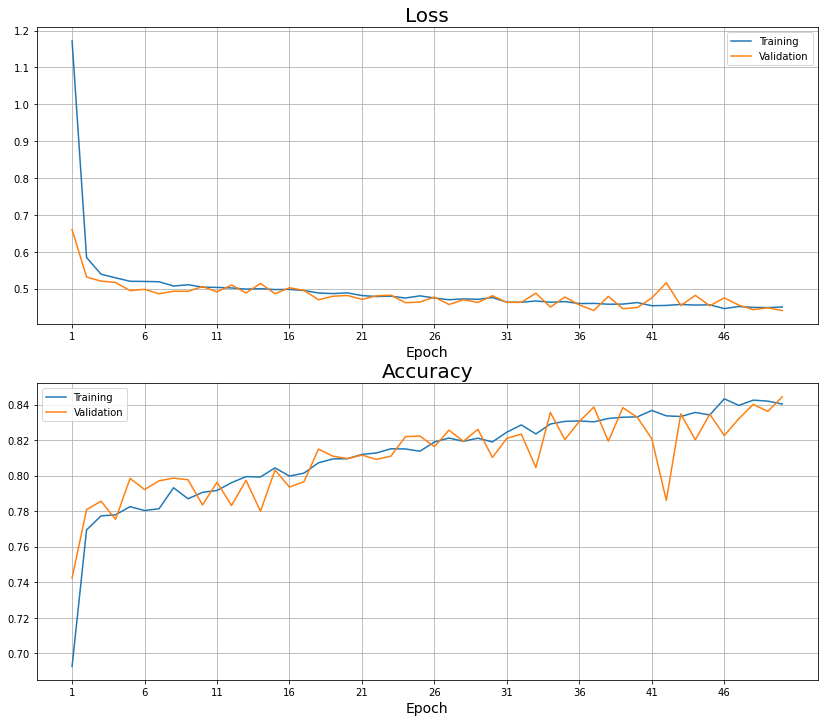

In [156]:
plt.figure(figsize=(14,12))

plt.subplot(2, 1, 1)

plt.plot(np.arange(1, 51), history_cnn2.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history_cnn2.history['val_loss'], label='Validation')
plt.title('Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.xticks(np.arange(1, 51, 5))
plt.grid()
plt.legend()


plt.subplot(2, 1, 2)

plt.plot(np.arange(1, 51), history_cnn2.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history_cnn2.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.xticks(np.arange(1, 51, 5))
plt.grid()
plt.legend()

plt.savefig('assets/pictures/4.DM_2_CNN_Loss_Acc_second_try.jpg')

plt.show()

### Evaluacija 

In [90]:
train_scores_cnn2 = cnn2.evaluate(X_train, y_train, batch_size=128)
print('Training set {0}: {1:.2f}%'.format(cnn2.metrics_names[1], train_scores_cnn2[1]))
print('Training set {0}: {1}'.format(cnn2.metrics_names[0], train_scores_cnn2[0]))

154/154 [==============================] - 30s 190ms/step - loss: 0.4025 - accuracy: 0.8607
Training set accuracy: 0.86%
Training set loss: 0.40246739983558655


In [91]:
test_scores_cnn2 = cnn2.evaluate(X_test, y_test, batch_size=128)
print('Test set {0}: {1:.2f}%'.format(cnn2.metrics_names[1], test_scores_cnn2[1]))
print('Test set {0}: {1}'.format(cnn2.metrics_names[0], test_scores_cnn2[0]))

52/52 [==============================] - 9s 174ms/step - loss: 0.4144 - accuracy: 0.8525
Test set accuracy: 0.85%
Test set loss: 0.4143528342247009


### Čuvanje modela konvolutivne neuronske mreže

In [169]:
with open('models/deep_models/DC_2_CNN_second_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(cnn2, model_file)

INFO:tensorflow:Assets written to: ram://a438d969-3186-47d3-adca-d784f93bf8de/assets


INFO:tensorflow:Assets written to: ram://a438d969-3186-47d3-adca-d784f93bf8de/assets


# 3. Uporedjivanje Train vs. Validation podataka neuronske i konvolutivne mreže
Samo popravljene verzije neuronske i konvolutivne mreže posmatramo ovde

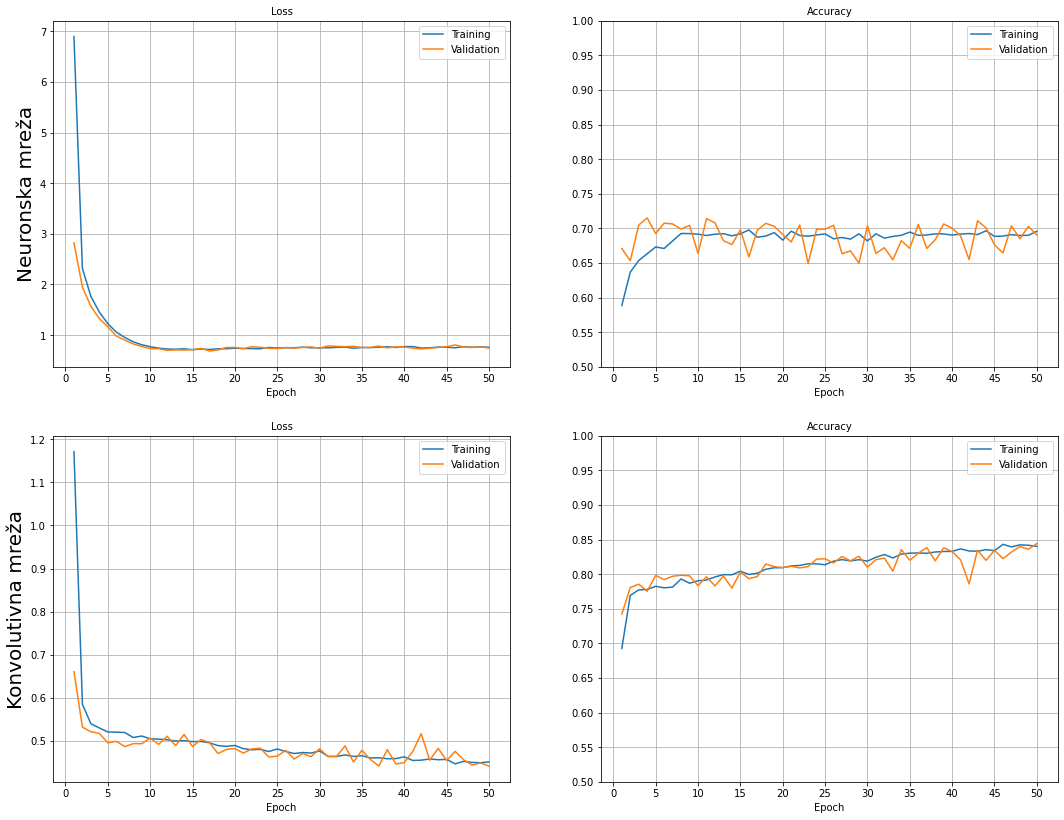

In [157]:
plt.figure(figsize=(18,14))

plt.subplot(2, 2, 1)

plt.title('Train vs. Validation - Neuronska i Konvolutivna mreža', size=20)
plt.ylabel('Neuronska mreža', size=20)

plt.plot(np.arange(1, 51), history2.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history2.history['val_loss'], label='Validation')
plt.title('Loss', size=10)
plt.xlabel('Epoch', size=10)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()


plt.subplot(2, 2, 2)

plt.plot(np.arange(1, 51), history2.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history2.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=10)
plt.xlabel('Epoch', size=10)
plt.xticks(np.arange(0,51,5))
plt.yticks(np.linspace(0.5,1,11))
plt.grid()
plt.legend()


plt.subplot(2, 2, 3)
plt.ylabel('Konvolutivna mreža', size=20)

plt.plot(np.arange(1, 51), history_cnn2.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history_cnn2.history['val_loss'], label='Validation')
plt.title('Loss', size=10)
plt.xlabel('Epoch', size=10)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()


plt.subplot(2, 2, 4)

plt.plot(np.arange(1, 51), history_cnn2.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history_cnn2.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=10)
plt.xlabel('Epoch', size=10)
plt.xticks(np.arange(0,51,5))
plt.yticks(np.linspace(0.5,1,11))
plt.grid()
plt.legend()

plt.savefig('assets/pictures/5.DM_Conclusion_ANN_vs_CNN.jpg')


plt.show()

### Uvećavanje slika i postavljanje na iste podeoke zbog preciznijeg uporedjivanja
Rezultati prvih nekoliko epoha će biti isečeni jer će se loss posmatrati na podeoku [0.4, 1], a accuracy na podeoku [0.6, 0.9] zbog preciznijeg uvida u odnos oba poboljšana modela. 

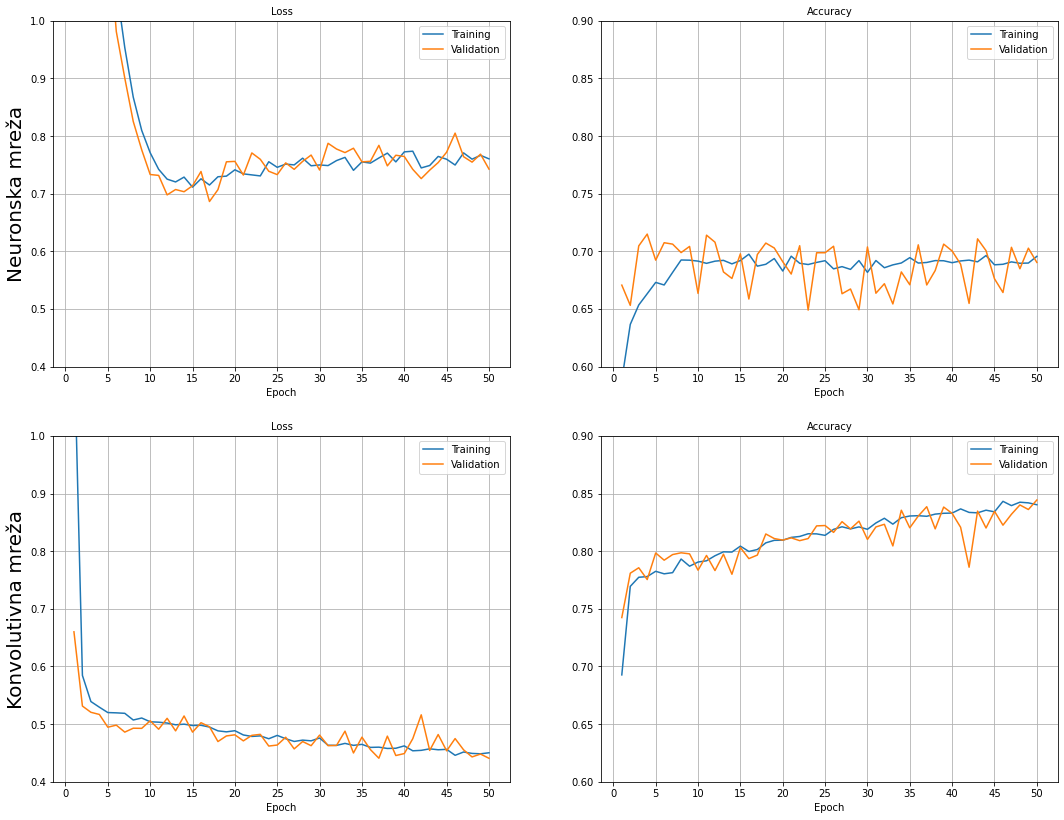

In [158]:
plt.figure(figsize=(18,14))

plt.subplot(2, 2, 1)

plt.title('Train vs. Validation - Neuronska i Konvolutivna mreža', size=20)
plt.ylabel('Neuronska mreža', size=20)

plt.plot(np.arange(1, 51), history2.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history2.history['val_loss'], label='Validation')
plt.title('Loss', size=10)
plt.xlabel('Epoch', size=10)
plt.ylim(0.4,1)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()


plt.subplot(2, 2, 2)

plt.plot(np.arange(1, 51), history2.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history2.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=10)
plt.xlabel('Epoch', size=10)
plt.ylim(0.6,0.9)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()


plt.subplot(2, 2, 3)
plt.ylabel('Konvolutivna mreža', size=20)

plt.plot(np.arange(1, 51), history_cnn2.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history_cnn2.history['val_loss'], label='Validation')
plt.title('Loss', size=10)
plt.xlabel('Epoch', size=10)
plt.ylim(0.4,1)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()


plt.subplot(2, 2, 4)

plt.plot(np.arange(1, 51), history_cnn2.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history_cnn2.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=10)
plt.xlabel('Epoch', size=10)
plt.ylim(0.6,0.9)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()

plt.savefig('assets/pictures/6.DM_Conclusion_ANN_vs_CNN_zoomed.jpg')


plt.show()

Kovolutivna mreža se ispostavila kao najbolji model za predikciju slika. 
Iz ovog grafika se vidi da bi potencijalno rezultat mogao biti bolji ako bi mreža duže bila trenirana, tako da je broj epoha dupliran u narednom delu koda.

# Uporedjivanje rezultata evaluacije nad test podacima
Pogledaćemo nad sva 4 trenirana modela (dva preprilagodjena i dva popravljena) kako su se kretali rezultati loss i accuracy nad test podacima.

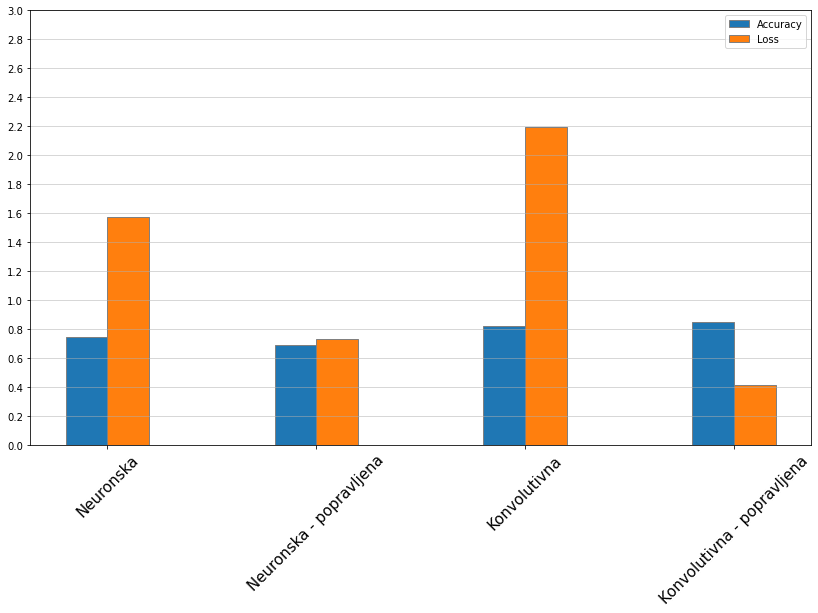

In [159]:
labels = ["Neuronska", "Neuronska - popravljena", "Konvolutivna", "Konvolutivna - popravljena"]
losses = [test_scores[0], test_scores2[0],test_scores_cnn[0], test_scores_cnn2[0]]
accs = [test_scores[1], test_scores2[1],test_scores_cnn[1], test_scores_cnn2[1]]
val_labels = ['Accuracy', 'Loss']
vals = [accs, losses]

x_axis = np.arange(len(labels))
move = [-1/2, 1/2]
width = 0.2
upper_y_lim = int(max(max(losses), max(accs))) + 1

plt.figure(figsize = (14,8))
for i in range(len(move)):
    plt.bar(x_axis + width*move[i], vals[i], width, edgecolor='gray')

plt.xticks(x_axis, labels, rotation = 45, size = 15)
plt.yticks(np.linspace(0, upper_y_lim, 16))

plt.legend(val_labels)
plt.grid(axis = 'y', linewidth = 0.5)

plt.savefig('assets/pictures/7.DM_eval_comparisson_ANN_CNN_all_models.jpg')

plt.show()

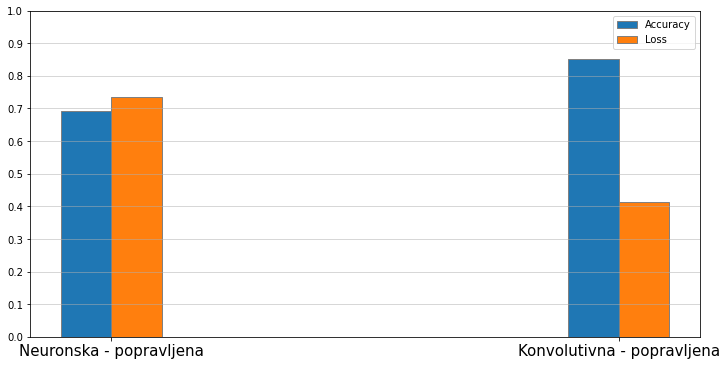

In [160]:
test_scores2
test_scores_cnn2

labels = ["Neuronska - popravljena", "Konvolutivna - popravljena"]
losses = [test_scores2[0], test_scores_cnn2[0]]
accs = [test_scores2[1], test_scores_cnn2[1]]
val_labels = ['Accuracy', 'Loss']
vals = [accs, losses]

x_axis = np.arange(len(labels))
move = [-1/2, 1/2]
width = 0.1
upper_y_lim = int(max(max(losses), max(accs))) + 1

plt.figure(figsize = (12,6))
for i in range(len(move)):
    plt.bar(x_axis + width*move[i], vals[i], width, edgecolor='gray')

plt.xticks(x_axis, labels, size = 15)
plt.yticks(np.linspace(0, upper_y_lim,(upper_y_lim+1)*5+1))

plt.legend(val_labels)
plt.grid(axis = 'y', linewidth = 0.5)

plt.savefig('assets/pictures/8.DM_eval_comparisson_ANN_CNN_fox_fixed_models.jpg')

plt.show()

# 4. Popravljena Konvolutivna mreža - trening na 100 epoha
Iz prethodnog se videlo da bi možda uz više epoha popravljena konvolutivna mreža mogla da da bolje rezultate, pa sa 50 epoha podižemo trening mreže na 100 epoha.

In [113]:
history_cnn3 = cnn2.fit(X_train,
                        y_train,
                        validation_data= (X_validation, y_validation),
                        batch_size=128,
                        epochs=100)

Epoch 1/100
154/154 [==============================] - 134s 872ms/step - loss: 0.4452 - accuracy: 0.8419 - val_loss: 0.5061 - val_accuracy: 0.8052
Epoch 2/100
154/154 [==============================] - 109s 706ms/step - loss: 0.4468 - accuracy: 0.8441 - val_loss: 0.4428 - val_accuracy: 0.8380
Epoch 3/100
154/154 [==============================] - 109s 708ms/step - loss: 0.4477 - accuracy: 0.8423 - val_loss: 0.4402 - val_accuracy: 0.8370
Epoch 4/100
154/154 [==============================] - 108s 700ms/step - loss: 0.4423 - accuracy: 0.8448 - val_loss: 0.4386 - val_accuracy: 0.8387
Epoch 5/100
154/154 [==============================] - 109s 707ms/step - loss: 0.4493 - accuracy: 0.8403 - val_loss: 0.4463 - val_accuracy: 0.8399
Epoch 6/100
154/154 [==============================] - 108s 699ms/step - loss: 0.4478 - accuracy: 0.8428 - val_loss: 0.4395 - val_accuracy: 0.8438
Epoch 7/100
154/154 [==============================] - 108s 699ms/step - loss: 0.4433 - accuracy: 0.8399 - val_loss: 0

### Finalna evaluacija konvolutivne mreže

In [119]:
print('Evaluacija nad trening podacima:\n')

train_scores_cnn_f = cnn2.evaluate(X_train, y_train, batch_size=128)
print('{0}: {1}'.format(loss, train_scores_cnn_f[0]))
print('{0}: {1}'.format(acc, train_scores_cnn_f[1]))

poboljšanje = 100 - (train_scores_cnn_f[0]*100)/train_scores_cnn2[0]

print('Poboljšanje: {:.2f}%'.format(poboljšanje))

Evaluacija nad trening podacima:

154/154 [==============================] - 31s 197ms/step - loss: 0.3363 - accuracy: 0.9094
loss: 0.3362806737422943
accuracy: 0.9094099402427673
Poboljšanje: 16.45%


In [163]:
print('Evaluacija nad test podacima:\n')

test_scores_cnn_f = cnn2.evaluate(X_test, y_test, batch_size=128)
print('Test set {0}: {1}'.format(loss, test_scores_cnn_f[0]))
print('Test set {0}: {1}'.format(acc, test_scores_cnn_f[1]))

poboljšanje = 100 - (test_scores_cnn_f[0]*100)/test_scores_cnn2[0]

print('Poboljšanje: {:.2f}%'.format(poboljšanje))

Evaluacija nad test podacima:

52/52 [==============================] - 9s 171ms/step - loss: 0.3965 - accuracy: 0.8744
Test set loss: 0.3965485692024231
Test set accuracy: 0.874427855014801
Poboljšanje: 4.30%


### Poboljšanje nakon dupliranja epoha

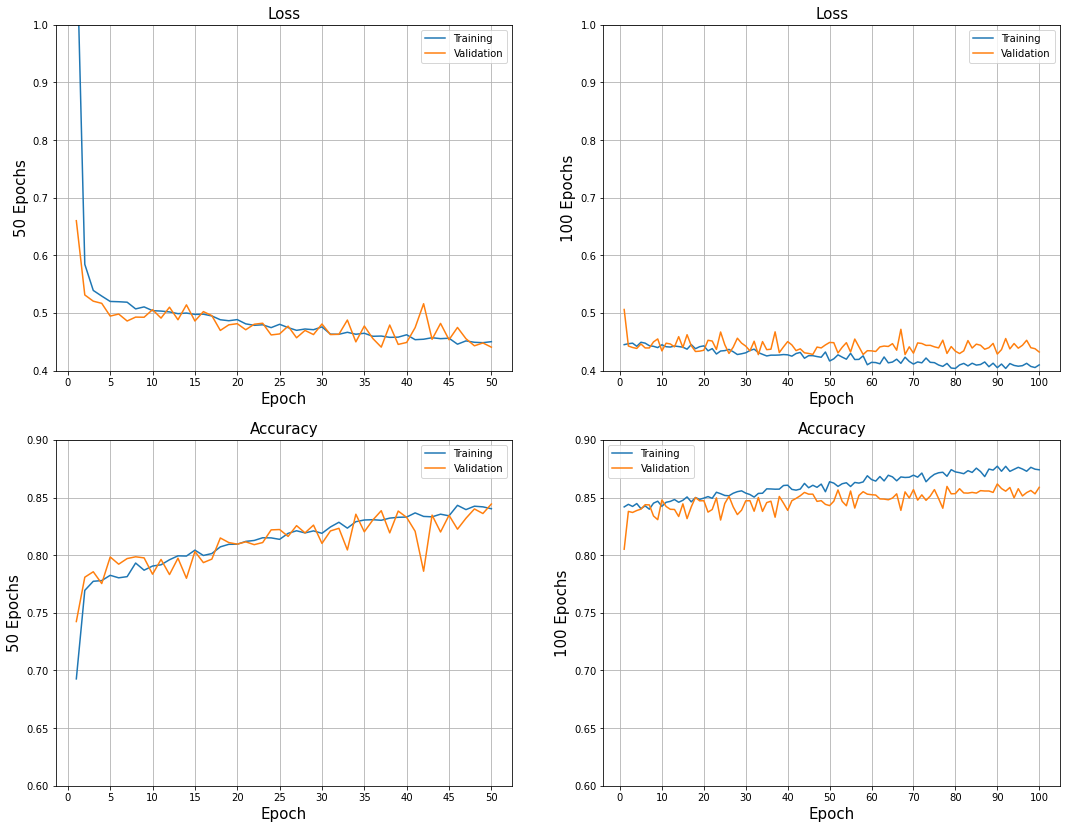

In [161]:
plt.figure(figsize=(18,14))

plt.subplot(2, 2, 1)

plt.plot(np.arange(1, 51), history_cnn2.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history_cnn2.history['val_loss'], label='Validation')
plt.title('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('50 Epochs', size=15)
plt.ylim(0.4,1)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()


plt.subplot(2, 2, 2)

plt.plot(np.arange(1, 101), history_cnn3.history['loss'], label='Training')
plt.plot(np.arange(1, 101), history_cnn3.history['val_loss'], label='Validation')
plt.title('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('100 Epochs', size=15)
plt.ylim(0.4,1)
plt.xticks(np.arange(0,101,10))
plt.grid()
plt.legend()



plt.subplot(2, 2, 3)

plt.plot(np.arange(1, 51), history_cnn2.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history_cnn2.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('50 Epochs', size=15)
plt.ylim(0.6,0.9)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()

plt.subplot(2, 2, 4)

plt.plot(np.arange(1, 101), history_cnn3.history['accuracy'], label='Training')
plt.plot(np.arange(1, 101), history_cnn3.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('100 Epochs', size=15)
plt.ylim(0.6,0.9)
plt.xticks(np.arange(0,101,10))
plt.grid()
plt.legend()

plt.savefig('assets/pictures/9.DM_final_CNN_comparisson_100_vs_50_epochs_zoomed.jpg')


plt.show()

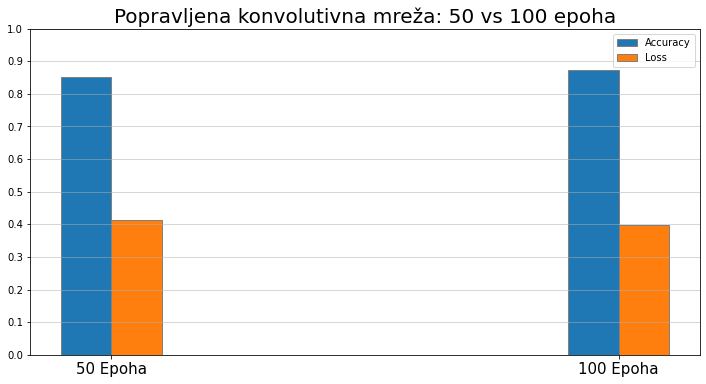

In [164]:
test_scores_cnn2
test_scores_cnn_f

labels = ["50 Epoha", "100 Epoha"]
losses = [test_scores_cnn2[0], test_scores_cnn_f[0]]
accs = [test_scores_cnn2[1], test_scores_cnn_f[1]]
val_labels = ['Accuracy', 'Loss']
vals = [accs, losses]

x_axis = np.arange(len(labels))
move = [-1/2, 1/2]
width = 0.1
upper_y_lim = int(max(max(losses), max(accs))) + 1

plt.figure(figsize = (12,6))
plt.title("Popravljena konvolutivna mreža: 50 vs 100 epoha", size = 20)
for i in range(len(move)):
    plt.bar(x_axis + width*move[i], vals[i], width, edgecolor='gray')

plt.xticks(x_axis, labels, size = 15)
plt.yticks(np.linspace(0, upper_y_lim,(upper_y_lim+1)*5+1))

plt.legend(val_labels)
plt.grid(axis = 'y', linewidth = 0.5)

plt.savefig('assets/pictures/10.DM_final_CNN_eval_comparisson_100_vs_50_epochs.jpg')

plt.show()

# Zaključak
Najbolji model koji je dobijen iz svih dosadašnjih klasifikacija je Konvolutivna neuronska mreža. U ovom slučaju, najbolji rezultat, dobijen nakon regularizacije i 100 epoha treniranja, je **87.44%** preciznosti predvidjanja slika limfnih čvorova.
Sigurno može još bolji rezultat da se dobije, ali ovaj model je ubedljivo bio bolji od svih ostalih iz klasičnog pristupa klasifikaciji, kao i obične neuralne mreže.